## import packages

In [13]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward


cuda is available


## define funcitons

In [14]:
def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected


In [ ]:
def run_one_step_policy(GAMMA_obj, policy_model, P, window):
    # Reference trajectory for temperature (original scale)
    mp_temp_ref = GAMMA_obj.ref[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P]  # [P, 1] or [P]
    mp_temp_ref_t = torch.as_tensor(mp_temp_ref, dtype=torch.float32, device=device).reshape(1, P, 1)  # [1, P, 1]
    # print("mp_temp_ref_t:", mp_temp_ref_t.shape)

    # Past input (original scale)
    mp_temp_past_t = GAMMA_obj.x_past.T.unsqueeze(0).to(device)  # [1, 50, 2]
    laser_past_t = GAMMA_obj.u_past.view(1, -1, 1).to(device)     # [1, 50, 1]

    laser_past_t = 0 * laser_past_t  # This line is redundant, but kept for consistency with the original code
    fix_cov_past = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter - window:GAMMA_obj.MPC_counter, :]
    fix_cov_past_t = torch.as_tensor(fix_cov_past, dtype=torch.float32, device=device).unsqueeze(0)  # [1, 50, 3]

    # print("mp_temp_past_t:", mp_temp_past_t.shape)
    # print("laser_past_t:", laser_past_t.shape)
    # print("fix_cov_past_t:", fix_cov_past_t.shape)

    # Normalize
    fix_cov_past_s = normalize_x(fix_cov_past_t, dim_id=[0, 1, 2])    # assume features 0~2 in x
    laser_past_s = normalize_x(laser_past_t, dim_id=[3])*0              # laser power at feature 3
    mp_temp_past_s = normalize_y(mp_temp_past_t, dim_id=[0, 1])       # temp and depth
    # print("mp_temp_past_s:", mp_temp_past_s.squeeze(0).cpu().numpy())
    # print("laser_past_s:", laser_past_s.squeeze(0).cpu().numpy())
    # print("fix_cov_past_s:", fix_cov_past_s.squeeze(0).cpu().numpy())


    policy_in_past = torch.cat((fix_cov_past_s, laser_past_s, mp_temp_past_s), dim=2)  # [1, 50, 6]
    # print("policy_in_past:", policy_in_past.shape)

    # Future covariates
    fix_cov_future = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P, :]
    fix_cov_future_t = torch.as_tensor(fix_cov_future, dtype=torch.float32, device=device).unsqueeze(0)  # [1, P, 3]
    fix_cov_future_s = normalize_x(fix_cov_future_t, dim_id=[0, 1, 2])
    mp_temp_ref_s = normalize_y(mp_temp_ref_t, dim_id=[0])[:, :, 0].unsqueeze(-1)

    # Constraints
    depth_upper_const = 0.4126
    depth_lower_const = 0.1423
    y_const_t = torch.tensor([[depth_upper_const, depth_lower_const]] * P, dtype=torch.float32, device=device).reshape(1, P, 2)
    y_const_s = normalize_y(y_const_t, dim_id=[1])  # assume dim=1 is depth

    policy_in_future = torch.cat((fix_cov_future_s, mp_temp_ref_s, y_const_s), dim=2)  # [1, P, 6]
    # print("policy_in_future:", policy_in_future.shape)

    # Policy inference
    u_pred = policy_model((policy_in_past, policy_in_future))
    u_first = u_pred[0,0]
    u_applied = float(inverse_normalize_x(u_first, dim_id=[3]))  # laser power
    # print("u_applied (original scale):", u_applied)

    # Simulate one step
    x_current, depth_current = GAMMA_obj.run_sim_interval(u_applied)
    # print("x_current, depth_current:", x_current, depth_current)

    # Update past sequence
    GAMMA_obj.x_past[:, :-1] = GAMMA_obj.x_past[:, 1:]
    GAMMA_obj.x_past[0, -1] = x_current
    GAMMA_obj.x_past[1, -1] = depth_current

    GAMMA_obj.u_past[:-1] = GAMMA_obj.u_past[1:].clone()
    GAMMA_obj.u_past[-1] = u_applied

    # Save state
    GAMMA_obj.x_hat_current = torch.tensor([x_current, depth_current], device=device)
    GAMMA_obj.x_sys_current = torch.tensor([[x_current], [depth_current]], device=device)
    GAMMA_obj.MPC_counter += 1

    # FIXED: device-matched saving
    new_state = torch.tensor([[x_current, depth_current]], device=GAMMA_obj.x_past_save.device)
    GAMMA_obj.x_past_save = torch.cat((GAMMA_obj.x_past_save, new_state), dim=0)

    new_u = torch.tensor([[u_applied]], device=GAMMA_obj.u_past_save.device)
    GAMMA_obj.u_past_save = torch.cat((GAMMA_obj.u_past_save, new_u), dim=0)

In [16]:
def plot_fig(MPC_GAMMA, N_step, save_path=None):
    plt.figure(figsize=[8, 6])

    plt.subplot(3, 1, 1)
    plt.plot(MPC_GAMMA.x_past_save[:N_step, 0], label="GAMMA simulation")
    plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
    plt.legend()
    plt.xlabel("MPC time step (*** sec/iteration)")
    plt.ylabel("Melt Pool Temperature (K)")

    plt.subplot(3, 1, 2)
    plt.plot(MPC_GAMMA.x_past_save[:N_step, 1], label="GAMMA simulation")
    plt.plot(np.linspace(0, N_step, N_step), 0.225 * np.ones(N_step), linestyle='--', label="Upper Bound")
    plt.plot(np.linspace(0, N_step, N_step), 0.075 * np.ones(N_step), linestyle='--', label="Lower Bound")
    plt.xlabel("MPC time step (*** sec/iteration)")
    plt.ylabel("Melt Pool Depth (mm)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(MPC_GAMMA.u_past_save[:N_step])
    plt.ylabel("Laser Power (W)")
    plt.xlabel("MPC time step (*** sec/iteration)")
    # plt.xlim(0, N_step)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Saved plot to {save_path}")
    else:
        plt.tight_layout()
        plt.show()


In [17]:
# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)


## read data

In [18]:
df_print = pd.read_csv('merged_df_2_99_temp_depth.csv')
output_dir = 'split_by_laser_power_number'
os.makedirs(output_dir, exist_ok=True)

unique_laser_numbers = sorted(df_print["laser_power_number"].unique())
for laser_num in unique_laser_numbers:
    df_filtered = df_print[df_print["laser_power_number"] == laser_num]
    output_path = os.path.join(output_dir, f"laser_power_number_{int(laser_num)}.csv")
    df_filtered.to_csv(output_path, index=False)
print(f"Saved: {output_path} ({len(df_filtered)} rows)")

Saved: split_by_laser_power_number/laser_power_number_99.csv (6295 rows)


In [24]:
import pandas as pd
import os

input_dir = 'split_by_laser_power_number'
output_dir = '/home/ftk3187/github/DPC_research/02_DED/2_policy/data/laser_inputs/single_track_square/laser_power_profiles/csv'
os.makedirs(output_dir, exist_ok=True)

for fname in sorted(os.listdir(input_dir)):
    if not fname.endswith('.csv'):
        continue

    df = pd.read_csv(os.path.join(input_dir, fname))
    new_df = pd.DataFrame()
    new_df['laser_power'] = df['Laser_power']
    new_df['time_elapsed'] = df['time_index']

    laser_number = ''.join(filter(str.isdigit, fname))

    output_fname = f"laser_profile_{laser_number}.csv"
    output_path = os.path.join(output_dir, output_fname)

    new_df.to_csv(output_path, index=False)
print(f"Saved: {output_fname}")


Saved: laser_profile_99.csv


## run loop

In [25]:
# df_one_print = pd.read_csv('single_track_ref.csv')
df_one_print = pd.read_csv('/home/ftk3187/github/DPC_research/02_DED/2_policy/split_by_laser_power_number/laser_power_number_2.csv')

In [26]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 #50 

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval, laser_power_number=2)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

100%|██████████| 250/250 [00:05<00:00, 46.03it/s]


In [22]:
loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)

# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)

# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

# apply moving average for mp depth
mp_depth_raw = df_one_print["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv

mp_depth_ref = torch.tensor(mp_depth,dtype=torch.float32)

# init_avg = torch.tensor(np.concatenate((mp_temp_ref[:window].reshape(-1,1), mp_depth_ref[:window].reshape(-1,1)),axis=1),dtype=torch.float32).T

print("mp_temp_ref.shape:", mp_temp_ref.shape)
print("mp_depth_ref.shape:", mp_depth_ref.shape)
print("init_avg.shape:", init_avg.shape)
print("init_avg:", init_avg)

mp_temp_ref.shape: torch.Size([6295])
mp_depth_ref.shape: torch.Size([6295])
init_avg.shape: torch.Size([2, 50])
init_avg: tensor([[ 4.0000e+02,  4.0000e+02,  4.6384e+02,  1.0845e+03,  1.7867e+03,
          2.0474e+03,  2.2191e+03,  2.2914e+03,  2.3331e+03,  2.3709e+03,
          2.3847e+03,  2.4045e+03,  2.4265e+03,  2.4325e+03,  2.4346e+03,
          2.4282e+03,  2.4250e+03,  2.4253e+03,  2.4274e+03,  2.4363e+03,
          2.4499e+03,  2.4606e+03,  2.4639e+03,  2.4715e+03,  2.4726e+03,
          2.4671e+03,  2.4699e+03,  2.4758e+03,  2.4827e+03,  2.4923e+03,
          2.4907e+03,  2.4919e+03,  2.4984e+03,  2.4913e+03,  2.4851e+03,
          2.4820e+03,  2.4805e+03,  2.4917e+03,  2.5023e+03,  2.4951e+03,
          2.4844e+03,  2.4826e+03,  2.4825e+03,  2.4903e+03,  2.5099e+03,
          2.5055e+03,  2.4874e+03,  2.4895e+03,  2.4935e+03,  2.5081e+03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.6633e-01, -5.4949e-01,
         -5.2806e-01, -4.8061e-01, -4.5459e-01, -4.3469e-01, -

GAMMA_class.ref.shape: torch.Size([6295])
GAMMA_class.fix_cov_all.shape: torch.Size([6295, 3])
GAMMA_class.x_past_save.shape: torch.Size([50, 2])
GAMMA_class.u_past_save.shape: torch.Size([50, 1])
GAMMA_class.x_past: torch.Size([2, 50])
GAMMA_class.u_past: torch.Size([50, 1])


  0%|          | 0/6195 [00:00<?, ?it/s]

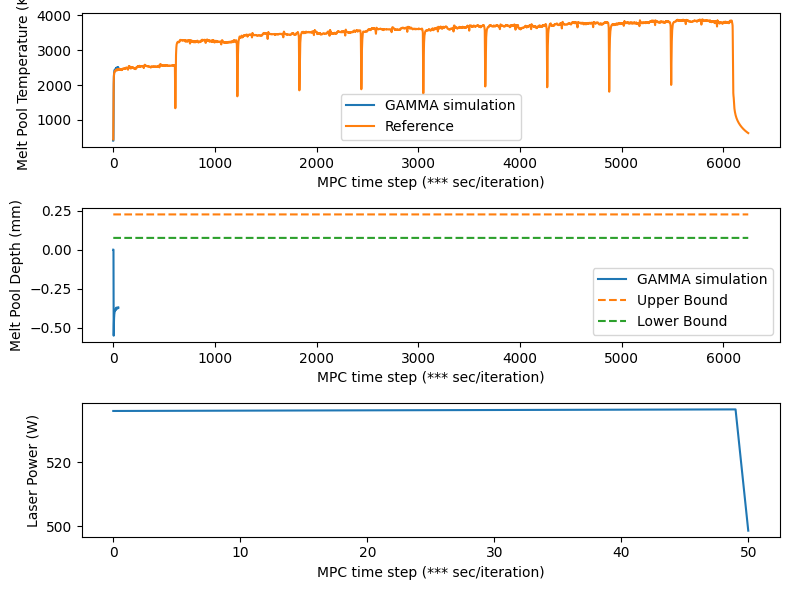

 16%|█▌        | 1000/6195 [01:56<10:12,  8.49it/s]

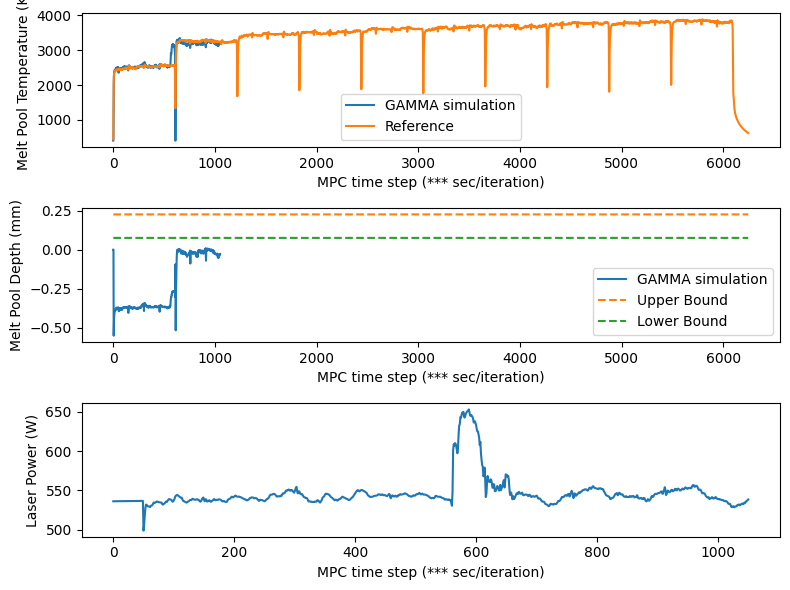

 32%|███▏      | 1998/6195 [02:52<02:46, 25.27it/s]

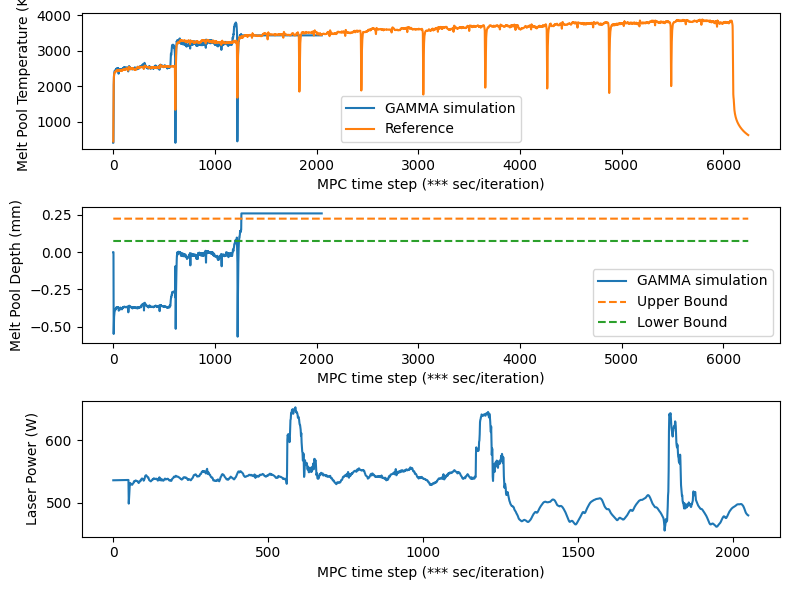

 47%|████▋     | 2893/6195 [03:28<03:58, 13.86it/s]


KeyboardInterrupt: 

In [ ]:
import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from tqdm import tqdm
import torch

P = 50
window = 50
N_step = len(mp_temp_ref) - P

model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=P,
    window=window,
    hidden_dim=64,
    n_layers=3,
    dropout_p=0.1
).to(device)

model_path = "/home/ftk3187/github/DPC_research/02_DED/2_policy/trainresults/policy_model_0717_cutdata_lr1e-4_3L_64H_s1_c1.pth"
# model_path = "/home/ftk3187/github/DPC_research/02_DED/2_policy/trainresults/policy_model_0716_epoch100_3L_1024H_s2_c2.pth"
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

# 초기화
GAMMA_class.ref = mp_temp_ref.clone()
GAMMA_class.fix_cov_all = fix_covariates.clone()
GAMMA_class.x_past = init_avg.clone()
GAMMA_class.u_past = laser_power_past.clone()

GAMMA_class.x_past_save = GAMMA_class.x_past.T.clone()
GAMMA_class.u_past_save = GAMMA_class.u_past.clone()
GAMMA_class.MPC_counter = window

GAMMA_class.x_hat_current = GAMMA_class.x_past[:, -1]
GAMMA_class.x_sys_current = GAMMA_class.x_past[:, -1].reshape(2, 1)

print("GAMMA_class.ref.shape:", GAMMA_class.ref.shape)
print("GAMMA_class.fix_cov_all.shape:", GAMMA_class.fix_cov_all.shape)
print("GAMMA_class.x_past_save.shape:", GAMMA_class.x_past_save.shape)
print("GAMMA_class.u_past_save.shape:", GAMMA_class.u_past_save.shape)

print("GAMMA_class.x_past:", GAMMA_class.x_past.shape)
print("GAMMA_class.u_past:", GAMMA_class.u_past.shape)        


# 실행 루프
for i in tqdm(range(N_step - P)):
    run_one_step_policy(GAMMA_class, model, P=P, window=window)

    # 원하는 구간마다 저장
    if i % 1000 == 0:
        plot_fig(GAMMA_class, N_step)
